# Predicting 2012 Presidential election

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [436]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import erf

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

In [4]:
#this mapping between states and abbreviations will come in handy later
states_abbrev = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

Here is some code to plot [State Chloropleth](https://en.wikipedia.org/wiki/Choropleth_map) maps in matplotlib. make_map is the function you will use

In [44]:
#adapted from  https://github.com/dataiap/dataiap/blob/master/resources/util/map_util.py

#load in state geometry
state2poly = defaultdict(list)

data = json.load(file("us-states.json"))
for k,v in states_abbrev.items():
    for f in data['features']:
        if v == f['properties']['name']:
            f['id'] = k
            state = states_abbrev[f['id']]
            geo = f['geometry']
            if geo['type'] == 'Polygon':
                for coords in geo['coordinates']:
                    state2poly[state].append(coords)
            elif geo['type'] == 'MultiPolygon':
                for polygon in geo['coordinates']:
                    state2poly[state].extend(polygon)

            
def draw_state(plot, stateid, **kwargs):
    """
    draw_state(plot, stateid, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    for polygon in state2poly[stateid]:
        xs, ys = zip(*polygon)
        plot.fill(xs, ys, **kwargs)

        
def make_map(states, label):
    """
    Draw a cloropleth map, that maps data onto the United States
    
    Inputs
    -------
    states : Column of a DataFrame
        The value for each state, to display on a map
    label : str
        Label of the color bar

    Returns
    --------
    The map
    """
    fig = plt.figure(figsize=(12, 9))
    ax = plt.gca()

    if states.max() < 2: # colormap for election probabilities 
        cmap = cm.RdBu
        vmin, vmax = 0, 1
    else:  # colormap for electoral votes
        cmap = cm.binary
        vmin, vmax = 0, states.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    skip = set(['National', 'District of Columbia', 'Guam', 'Puerto Rico',
                'Virgin Islands', 'American Samoa', 'Northern Mariana Islands'])
    for state in states_abbrev.values():
        if state in skip:
            continue
        color = cmap(norm(states.ix[state]))
        draw_state(ax, state, color = color, ec='k')

    #add an inset colorbar
    ax1 = fig.add_axes([0.45, 0.70, 0.4, 0.02])    
    cb1=mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                  norm=norm,
                                  orientation='horizontal')
    ax1.set_title(label)
    remove_border(ax, left=False, bottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-180, -60)
    ax.set_ylim(15, 75)
    return ax

In [45]:
# just Testing
data = json.load(file("us-states.json"))
for k,v in states_abbrev.items():
    for f in data['features']:
        if v == f['properties']['name']:
            f['id'] = k
            state = states_abbrev[f['id']]
            #print state

In [46]:
# We are pretending to build our model 1 month before the election
import datetime
today = datetime.datetime(2012, 10, 2)
today

datetime.datetime(2012, 10, 2, 0, 0)

In [48]:
# Here is the electoral vote breakdown by state
electoral_votes = pd.read_csv('./hw2_data/data/electoral_votes.csv').set_index('State')
electoral_votes.head()

,Votes
State,
California,55
Texas,38
New York,29
Florida,29
Illinois,20


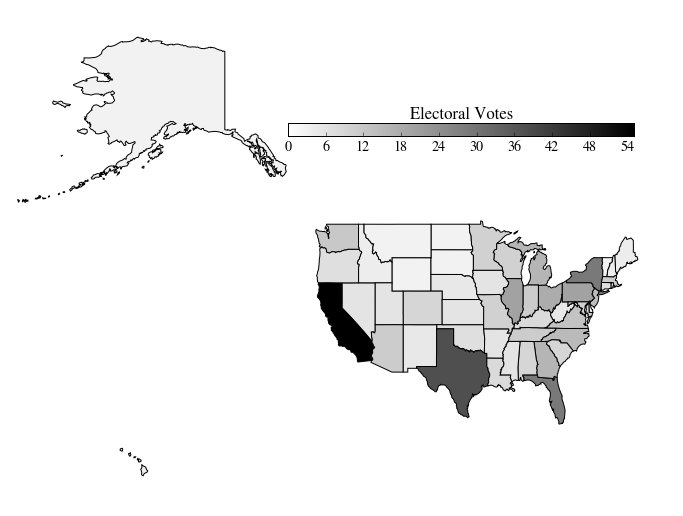

In [49]:
# To illustrate the use of make_map we plot the Electoral College
make_map(electoral_votes.Votes, "Electoral Votes");

#Question 1: Simulating elections

The PredictWise Baseline:

We will start by examining a successful forecast that [PredictWise](http://www.predictwise.com/results/2012/president) made on October 2, 2012(1:00 AM). This will give us a point of comparison for our own forecast models.

PredictWise aggregated polling data and, for each state, estimated the probability that the Obama or Romney would win. Here are those estimated probabilities:

In [51]:
predictwise = pd.read_csv('./hw2_data/data/predictwise.csv').set_index('States')
predictwise.head()

,Obama,Romney,Votes
States,,,
Alabama,0.000,1.000,9
Alaska,0.000,1.000,3
Arizona,0.062,0.938,11
Arkansas,0.000,1.000,6
California,1.000,0.000,55


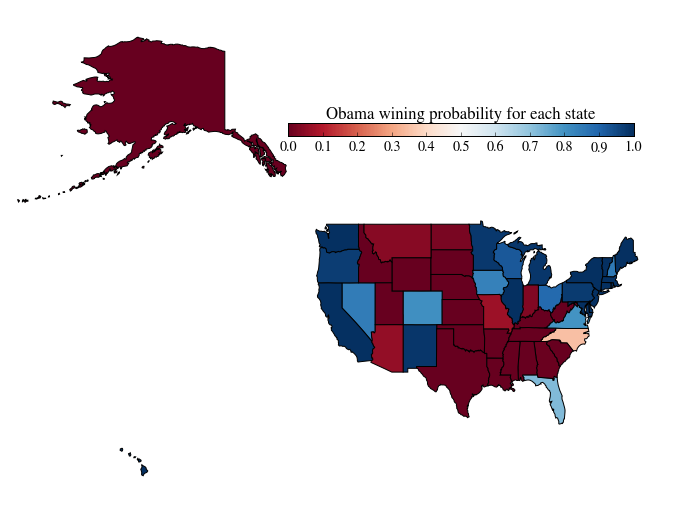

In [54]:
# make-map representation of the predictwise data
# 1.1 Use make_map to plot a map of the probability that Obama wins each state, according to this prediction.
make_map(predictwise.Obama, "Obama wining probability for each state");

In [259]:
# 1.2
# We will assume that the outcome in each state is the result of an independent coin flip whose probability of coming up Obama 
# s given by a Dataframe of state-wise win probabilities.
# Write a function that uses this predictive model to simulate the outcome of the election given a Dataframe of probabilities.

predictwise_obama=predictwise[['Obama','Votes']]
def simulate_election(df, n_sim):
    # each column simulates a single outcome from the 50 states + DC
    # Obama wins the simulation if the random number is < the win probability
    # the simulations is a 2D, of 51rows * n_sim columns
    simulations = np.random.uniform(size=(51,n_sim))
    # Creating a list of tuples, where each tupple, where first tuple has boolean values depending upon the comparison,
    # length is equal to n_sim and second tuple contains number of votes from each state.
    zipped=zip((simulations < predictwise_obama.Obama.reshape(-1,1)),predictwise_obama.Votes.reshape(-1,1))
    votes_won_obama=[]
    for p,v in zipped:
        # p is list of length equal to n_sim and v is list and their product creates a list.
        # p=[False, False, False] and v[9], p*v gives [0,0,0]
        votes_won_obama.append(p*v)
    # creating a numpy array of shape 51rows*n_sim columns
    obama_votes=np.array(votes_won_obama)
    # sum over rows mean--- means the axis=0(as axis=0 means rows) and it happens in vertical fashion(top to down)
    return obama_votes.sum(axis=0)

In [260]:
result = simulate_election(predictwise_obama, 10000)

We use the results to compute the probability, according to this predictive model, that Obama wins the election (i.e., the probability that he receives 269 or more electoral college votes)

In [283]:
#compute the probability of an Obama win, given this simulation
prob_obama_win=float(len(np.extract(result>269, result)))/len(result)
print "Probability of an Obama win, given this simulation is %f "% prob_obama_win

Probability of an Obama win, given this simulation is 0.996100 


1.3 Now, write a function called plot_simulation to visualize the simulation

In [344]:
def plot_simulation(result):
    plt.hist(result, bins=60, label='result', align='left')
    plt.xlabel('Number of Votes')
    plt.ylabel('Probability')
    plt.ticklabel_format(style='sci',axis='y', scilimits=(0,1))
    plt.title('Chance of Obama Victory 99.61%')
    # Overplot the "victory threshold" of 269 votes as a vertical black line 
    plt.axvline(269, color='0', linewidth=2, label='Victory Threshold')
    # Overplot the result (Obama winning 332 votes) as a vertical red line
    plt.axvline(332, color='r', linewidth=2, label='Actual Vote')
    plt.legend(frameon=False, loc='best')
    remove_border()

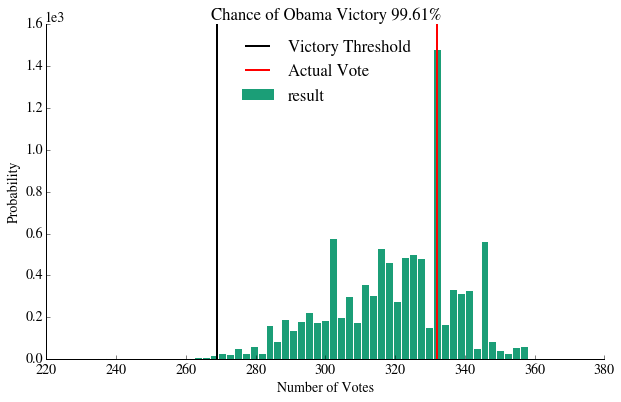

In [345]:
plot_simulation(result)

#Gallup Party Affiliation Poll

Now we will try to estimate our own win probabilities to plug into our predictive model.

We will start with a simple forecast model. We will try to predict the outcome of the election based the estimated proportion of people in each state who identify with one one political party or the other.

Gallup measures the political leaning of each state, based on asking random people which party they identify or affiliate with.

In [351]:
gallup_data_2012=pd.read_csv('./hw2_data/data/g12.csv').set_index('State')
gallup_data_2012["Unknown"] = 100 - gallup_data_2012.Democrat - gallup_data_2012.Republican
gallup_data_2012.head()

,Democrat,Republican,Dem_Adv,N,Unknown
State,,,,,
Alabama,36.0,49.6,-13.6,3197,14.4
Alaska,35.9,44.3,-8.4,402,19.8
Arizona,39.8,47.3,-7.5,4325,12.9
Arkansas,41.5,40.8,0.7,2071,17.7
California,48.3,34.6,13.7,16197,17.1


This survey can be used to predict the outcome of each State's election. The simplest forecast model assigns 100% probability that the state will vote for the majority party. 
Implement this simple forecast.

In [389]:
def simple_gallup_model(dataframe):
    gallup_obama_predict=gallup_data_2012[[]]
    gallup_obama_predict['Obama']=gallup_data_2012.Democrat > gallup_data_2012.Republican
    gallup_obama_predict['Obama']=gallup_obama_predict['Obama'].apply(lambda x: 1 if x == True else 0)
    return gallup_obama_predict

In [392]:
simple_gallup_model(gallup_data_2012).ix['Arkansas']

C:\Users\sanjiv\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\sanjiv\Anaconda\lib\site-packages\IPython\kernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Obama    1
Name: Arkansas, dtype: int64

Now, we run the simulation with this model, and plot it.

C:\Users\sanjiv\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\sanjiv\Anaconda\lib\site-packages\IPython\kernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


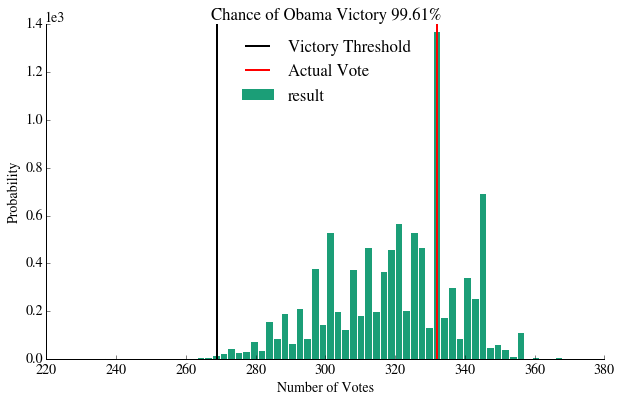

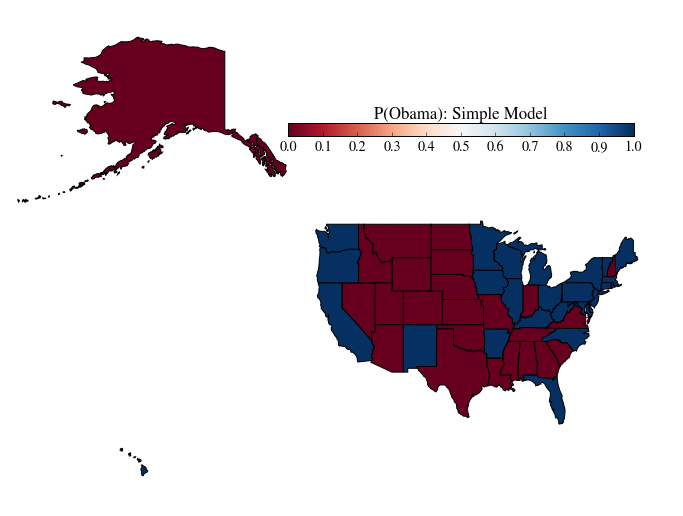

In [393]:
model = simple_gallup_model(gallup_data_2012)
model = model.join(electoral_votes)
prediction = simulate_election(model, 10000)

plot_simulation(prediction)
plt.show()
make_map(model.Obama, "P(Obama): Simple Model")

In [471]:
def uncertain_gallup_model(gallup):
    std_dev=3
    z=0
    cdf_prob=[]
    for i in gallup.Dem_Adv.values:
        cdf_prob.append(1.0/2.0*((1+math.erf(i))*((i)/math.sqrt(2*(std_dev**2)))))
    gallup_obama_uncertain_predict['Obama']=np.array(cdf_prob)
    return gallup_obama_uncertain_predict

In [472]:
gallup_data_2012.head()

,Democrat,Republican,Dem_Adv,N,Unknown
State,,,,,
Alabama,36.0,49.6,-13.6,3197,14.4
Alaska,35.9,44.3,-8.4,402,19.8
Arizona,39.8,47.3,-7.5,4325,12.9
Arkansas,41.5,40.8,0.7,2071,17.7
California,48.3,34.6,13.7,16197,17.1


In [473]:
model = uncertain_gallup_model(gallup_data_2012)
model = model.join(electoral_votes)

C:\Users\sanjiv\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [474]:
model.Obama

State
Alabama                -0.000000e+00
Alaska                 -0.000000e+00
Arizona                -0.000000e+00
Arkansas                1.384115e-01
California              3.229121e+00
Colorado               -1.179767e-13
Connecticut             3.629815e+00
Delaware                4.101219e+00
District of Columbia    1.562706e+01
Florida                 1.384115e-01
Georgia                -7.267765e-09
Hawaii                  6.033978e+00
Idaho                  -0.000000e+00
Illinois                2.969848e+00
Indiana                -0.000000e+00
Iowa                    4.219498e-01
Kansas                 -0.000000e+00
Kentucky                6.733506e-02
Louisiana              -6.421741e-12
Maine                   1.037090e+00
Maryland                4.761186e+00
Massachusetts           4.501913e+00
Michigan                2.616295e+00
Minnesota               2.404163e+00
Mississippi            -0.000000e+00
Missouri               -1.599119e-08
Montana                -0.000000

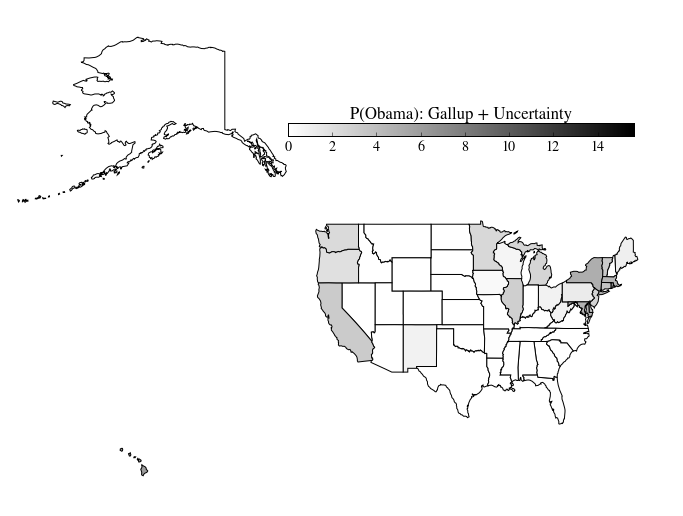

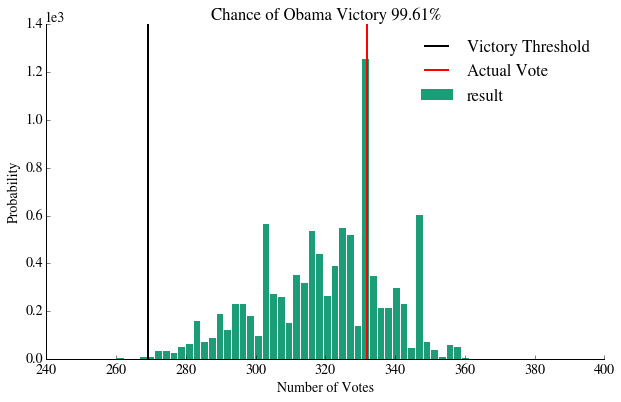

In [475]:
make_map(model.Obama, "P(Obama): Gallup + Uncertainty")
plt.show()
prediction = simulate_election(model, 10000)
plot_simulation(prediction)

In [ ]:
from scipy.special import erf
def uncertain_gallup_model(gallup):
    sigma = 3
    prob =  .5 * (1 + erf(gallup.Dem_Adv / np.sqrt(2 * sigma**2)))
    return pd.DataFrame(dict(Obama=prob), index=gallup.index)

Implement a biased_gallup forecast, which assumes the vote share for the Democrat on election day will be equal 
to Dem_Adv shifted by a fixed negative amount. We will call this shift the "bias", so a bias of 1% means that the expected 
vote share on election day is Dem_Adv-1.

In [476]:
def biased_gallup(gallup, bias):
    g2 = gallup.copy()
    g2.Dem_Adv -= bias
    return uncertain_gallup_model(g2)

In [487]:
model = biased_gallup(gallup_data_2012, 1)
model = model.join(electoral_votes)

C:\Users\sanjiv\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [488]:
model.ix['Florida']

Obama    -0.023737
Votes    29.000000
Name: Florida, dtype: float64

Simulate elections assuming a bias of 1% and 5%, and plot histograms for each one

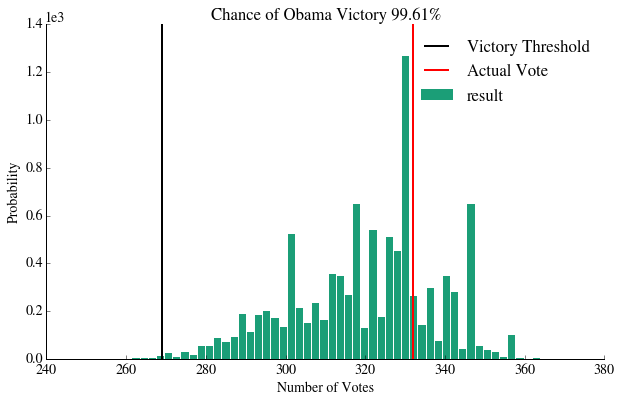

In [489]:
plt.show()
prediction = simulate_election(model, 10000)
plot_simulation(prediction)

C:\Users\sanjiv\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


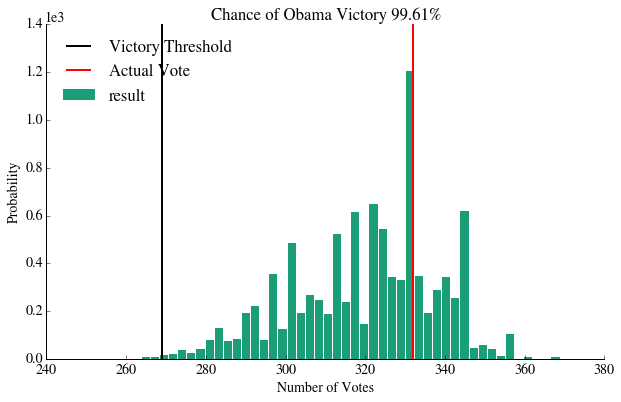

In [490]:
model = biased_gallup(gallup_data_2012, 5)
model = model.join(electoral_votes)
prediction = simulate_election(model, 10000)
plot_simulation(prediction)
plt.show()

Estimating the size of the bias from the 2008 election
While bias can lead to serious inaccuracy in our predictions, it is fairly easy to correct if we are able to estimate the size of the bias and adjust for it. This is one form of calibration.

One approach to calibrating a model is to use historical data to estimate the bias of a prediction model. We can use our same prediction model on historical data and compare our historical predictions to what actually occurred and see if, on average, the predictions missed the truth by a certain amount. Under some assumptions (discussed in a question below), we can use the estimate of the bias to adjust our current forecast.

In this case, we can use data from the 2008 election. (The Gallup data from 2008 are from the whole of 2008, including after the election):

In [578]:
gallup_08 = pd.read_csv("./hw2_data/data/g08.csv").set_index('State')
results_08 = pd.read_csv('./hw2_data/data/2008results.csv').set_index('State')

prediction_08 = gallup_08[['Dem_Adv']]
prediction_08['Dem_Win']=results_08["Obama Pct"] - results_08["McCain Pct"]
prediction_08.head()


C:\Users\sanjiv\Anaconda\lib\site-packages\IPython\kernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Dem_Adv,Dem_Win
State,,
Alabama,-0.8,-21.58
Alaska,-10.6,-21.53
Arizona,-0.4,-8.52
Arkansas,12.5,-19.86
California,19.4,24.06


In [496]:
results_08.head()

,Obama,McCain,Nader,Barr,Baldwin,McKinney,Others,Total,Unnamed: 9,Obama Pct,McCain Pct,O Rounded,M Rounded
State,,,,,,,,,,,,,
Alabama,"813,479","1,266,546","6,788","4,991","4,310",0,"3,705","2,099,819",NaN,38.74,60.32,39,60
Alaska,"123,594","193,841","3,783","1,589","1,660",0,"1,730","326,197",NaN,37.89,59.42,38,59
Arizona,"1,034,707","1,230,111","11,301","12,555","1,371","3,406",24,"2,293,475",NaN,45.12,53.64,45,54
Arkansas,"422,310","638,017","12,882","4,776","4,023","3,470","1,139","1,086,617",NaN,38.86,58.72,39,59
California,"8,274,473","5,011,781","108,381","67,582","3,145","38,774","57,764","13,561,900",NaN,61.01,36.95,61,37


In [494]:
prediction_08.describe()

,Dem_Adv,Dem_Win
count,51.000000,51.000000
mean,12.354902,4.286863
std,15.832035,22.085850
min,-22.700000,-32.240000
25%,3.000000,-13.150000
50%,12.500000,4.540000
75%,18.950000,16.820000
max,75.400000,85.930000


Make a scatter plot using the prediction_08 dataframe of the democratic advantage in the 2008 Gallup poll (X axis) compared to the democratic win percentage -- the difference between Obama and McCain's vote percentage -- in the election (Y Axis). Overplot a linear fit to these data.

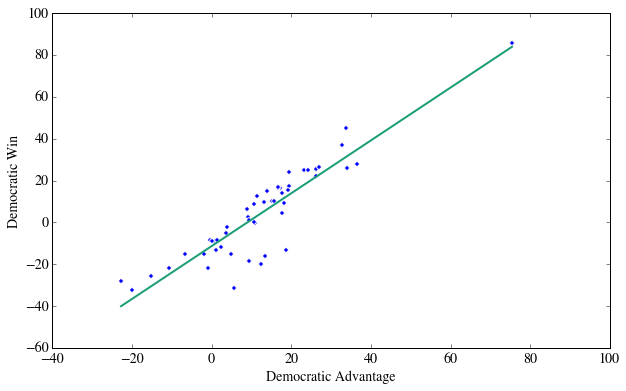

In [504]:
x=prediction_08.Dem_Adv.values
y=prediction_08.Dem_Win.values

plt.scatter(prediction_08.Dem_Adv, prediction_08.Dem_Win)
plt.xlabel('Democratic Advantage')
plt.ylabel('Democratic Win')
par = np.polyfit(x, y, 1, full=True)
slope=par[0][0]
intercept=par[0][1]
xl = [min(x), max(x)]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl,yl)
plt.show()

A quick look at the graph will show you a number of states where Gallup showed a Democratic advantage, but where the elections were lost by the democrats. Use Pandas to list these states

In [530]:
prediction_08['Dem_Adv']=prediction_08.Dem_Adv.apply(lambda x:x >0)
prediction_08['Dem_Win']=prediction_08.Dem_Win.apply(lambda x:x <0)

C:\Users\sanjiv\Anaconda\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\sanjiv\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [537]:
prediction_08[(prediction_08['Dem_Adv'] == True) & (prediction_08['Dem_Win'] == True)]

,Dem_Adv,Dem_Win
State,,
Arkansas,True,True
Georgia,True,True
Kentucky,True,True
Louisiana,True,True
Mississippi,True,True
Missouri,True,True
Montana,True,True
North Dakota,True,True
Oklahoma,True,True


In [541]:
print (prediction_08.Dem_Adv - prediction_08.Dem_Win).mean()

0.725490196078


C:\Users\sanjiv\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


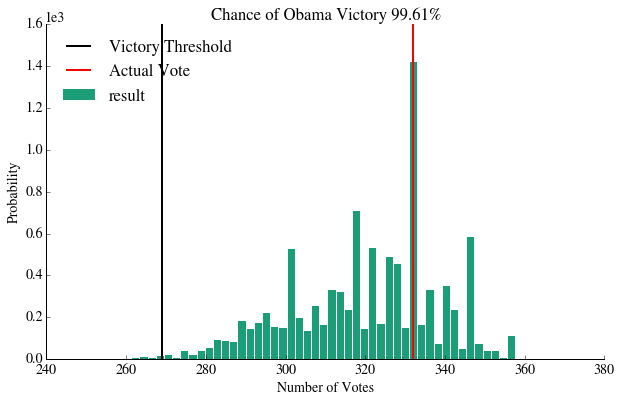

In [542]:
# Use bias from above i.e. 7.2
model = biased_gallup(gallup_data_2012, 7.2)
model = model.join(electoral_votes)
prediction = simulate_election(model, 10000)
plot_simulation(prediction)
plt.show()

First, we'll construct a new feature called PVI, and use it and the Gallup poll to build predictions. Then, we'll use logistic regression to estimate win probabilities, and use these probabilities to build a prediction.

#The Partisan Voting Index

The Partisan Voting Index (PVI) is defined as the excessive swing towards a party in the previous election in a given state. In other words:

PVI2008(state)=Democratic.Percent2004(state)−Republican.Percent2004(state)−(Democratic.Percent2004(national)−Republican.Percent2004(national))

To calculate it, let us first load the national percent results for republicans and democrats in the last 3 elections and convert it to the usual democratic - republican format.

In [548]:
national_results=pd.read_csv("./hw2_data/data/nat.csv")
national_results.set_index('Year',inplace=True)
national_results

,Dem,Rep
Year,,
2004,48,51
2008,53,46
2012,51,47


Let us also load in data about the 2004 elections from p04.csv which gets the results in the above form for the 2004 election for each state.

In [549]:
polls04=pd.read_csv("./hw2_data/data/p04.csv")
polls04.State=polls04.State.replace(states_abbrev)
polls04.set_index("State", inplace=True);
polls04.head()

,Dem,Rep
State,,
Alabama,37,63
Alaska,34,62
Arizona,44,55
Arkansas,45,54
California,54,45


In [552]:
pvi08=polls04.Dem - polls04.Rep - (national_results.xs(2004)['Dem'] - national_results.xs(2004)['Rep'])
pvi08.head()

State
Alabama      -23
Alaska       -25
Arizona       -8
Arkansas      -6
California    12
dtype: int64

In [566]:
type(pvi08)

pandas.core.series.Series

In [644]:
prediction_08.head()

,Dem_Adv,Dem_Win
State,,
Alabama,-0.8,-21.58
Alaska,-10.6,-21.53
Arizona,-0.4,-8.52
Arkansas,12.5,-19.86
California,19.4,24.06


In [560]:
e2008=pd.DataFrame([])

In [580]:
e2008.loc[prediction_08.index, prediction_08.columns]=prediction_08

In [581]:
e2008.head()

,Dem_Adv,Dem_Win,pvi
State,,,
Alabama,-0.8,-21.58,-23
Alaska,-10.6,-21.53,-25
Arizona,-0.4,-8.52,-8
Arkansas,12.5,-19.86,-6
California,19.4,24.06,12


In [567]:
e2008['pvi']=pvi08

C:\Users\sanjiv\Anaconda\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [608]:
e2008['Dem_Adv']=e2008.Dem_Adv.apply(lambda x: x-e2008.Dem_Adv.mean())

In [602]:
e2008['obama_win']=prediction_08.Dem_Win > 0

In [606]:
e2008['obama_win']=e2008.obama_win.apply(lambda x: 1 if x == True else 0)

In [651]:
e2008 = e2008.sort_index()
e2008.head()

,Dem_Adv,Dem_Win,pvi,obama_win
State,,,,
Alabama,-13.154902,-21.58,-23,0
Alaska,-22.954902,-21.53,-25,0
Arizona,-12.754902,-8.52,-8,0
Arkansas,0.145098,-19.86,-6,0
California,7.045098,24.06,12,1


In [ ]:
#Simple code to create e2008 Dataframe:
# e2008=pd.DataFrame(dict(pvi=pvi08, Dem_Win = prediction_08.Dem_Win, Dem_Adv=prediction_08.Dem_Adv-prediction_08.Dem_Adv.mean()))
# e2008['obama_win']=1*(prediction_08.Dem_Win > 0)
# e2008 = e2008.sort_index()
# e2008.head()

We construct a similar frame for 2012, obtaining pvi using the 2008 Obama win data which we already have. There is no obama_win column since, well, our job is to predict it!

In [638]:
pvi12 = e2008.Dem_Win - (national_results.xs(2008)['Dem'] - national_results.xs(2008)['Rep'])
e2012 = pd.DataFrame(dict(pvi=pvi12, Dem_Adv=gallup_data_2012.Dem_Adv - gallup_data_2012.Dem_Adv.mean()))
e2012 = e2012.sort_index()
e2012.head()

,Dem_Adv,pvi
State,,
Alabama,-14.684314,-28.58
Alaska,-9.484314,-28.53
Arizona,-8.584314,-15.52
Arkansas,-0.384314,-26.86
California,12.615686,17.06


We load in the actual 2012 results so that we can compare our results to the predictions.

In [639]:
results2012 = pd.read_csv("./hw2_data/data/2012results.csv")
results2012.set_index("State", inplace=True)
results2012 = results2012.sort_index()
results2012.head()

,Winner
State,
Alabama,0
Alaska,0
Arizona,0
Arkansas,0
California,1


In [641]:
e2008.pvi.describe()

count    51.000000
mean     -3.039216
std      21.151795
min     -43.000000
25%     -17.000000
50%      -4.000000
75%      10.000000
max      84.000000
Name: pvi, dtype: float64

In [642]:
e2012.pvi.describe()

count    51.000000
mean     -2.713137
std      22.085850
min     -39.240000
25%     -20.150000
50%      -2.460000
75%       9.820000
max      78.930000
Name: pvi, dtype: float64

Exploratory Data Analysis

2.2 Lets do a little exploratory data analysis. Plot a scatter plot of the two PVi's against each other. What are your findings? Is the partisan vote index relatively stable from election to election?

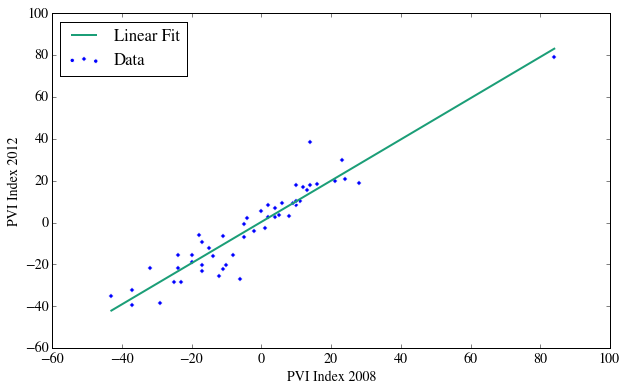

In [647]:
x=e2008.pvi
y=e2012.pvi
plt.scatter(e2008.pvi, e2012.pvi, label='Data')
plt.xlabel('PVI Index 2008')
plt.ylabel('PVI Index 2012')
par = np.polyfit(x, y, 1, full=True)
slope=par[0][0]
intercept=par[0][1]
xl = [min(x), max(x)]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl,yl, label='Linear Fit')
plt.legend(loc='best')
plt.show()

2.3  Lets do a bit more exploratory data analysis. Using a scatter plot, plot Dem_Adv against pvi in both 2008 and 2012. Use colors red and blue depending upon obama_win for the 2008 data points. Plot the 2012 data using gray color. Is there the possibility of making a linear separation (line of separation) between the red and the blue points on the graph?

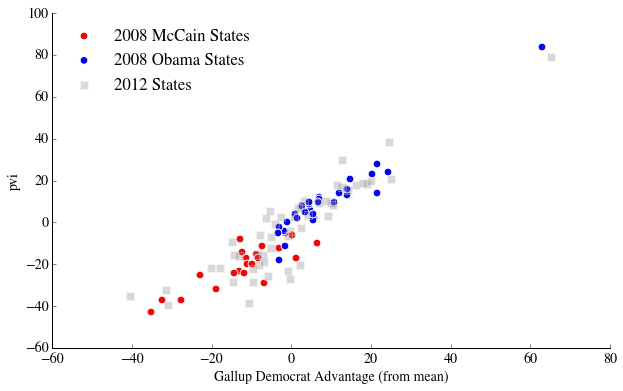

In [660]:
plt.xlabel("Gallup Democrat Advantage (from mean)")
plt.ylabel("pvi")
colors=["red","blue"]
ax=plt.gca()
for label in [0, 1]:
    color = colors[label]
    mask = e2008.obama_win == label
    l = '2008 McCain States' if label == 0 else '2008 Obama States'
    ax.scatter(e2008[mask]['Dem_Adv'], e2008[mask]['pvi'], c=color, s=60, label=l)

ax.scatter(e2012['Dem_Adv'], e2012['pvi'], c='gray', s=60, 
           marker="s", label='2012 States', alpha=.3)
plt.legend(frameon=False, scatterpoints=1, loc='upper left')
remove_border()

#Logistic Regression

In [661]:
from sklearn.linear_model import LogisticRegression

def prepare_features(frame2008, featureslist):
    y= frame2008.obama_win.values
    X = frame2008[featureslist].values
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    return y, X

In [688]:
def fit_logistic(frame2008, frame2012, featureslist, reg=0.0001):
    y, X = prepare_features(frame2008, featureslist)
    clf2 = LogisticRegression(C=reg)
    clf2.fit(X, y)
    X_new = frame2012[featureslist]
    obama_probs = clf2.predict_proba(X_new)[:, 1]
    
    df = pd.DataFrame(index=frame2012.index)
    df['Obama'] = obama_probs
    return df, clf2

In [689]:
from sklearn.grid_search import GridSearchCV

def cv_optimize(frame2008, featureslist, n_folds=10, num_p=100):
    y, X = prepare_features(frame2008, featureslist)
    clf = LogisticRegression()
    parameters = {"C": np.logspace(-4, 3, num=num_p)}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    return gs.best_params_, gs.best_score_

In [690]:
def cv_and_fit(frame2008, frame2012, featureslist, n_folds=5):
    bp, bs = cv_optimize(frame2008, featureslist, n_folds=n_folds)
    predict, clf = fit_logistic(frame2008, frame2012, featureslist, reg=bp['C'])
    return predict, clf

*Carry out a logistic fit using the cv_and_fit function developed above. As your featurelist use the features we have: Dem_Adv and pvi.

In [692]:
prediction_2012, Regression_Object=cv_and_fit(e2008, e2012,['Dem_Adv', 'pvi'], 5)

In [ ]:
prediction_2012.join(electoral_votes)

In [709]:
prediction_2012.head()

,Obama,Votes
State,,
Alabama,0.004367,9
Alaska,0.008462,3
Arizona,0.068250,11
Arkansas,0.033851,6
California,0.994326,55


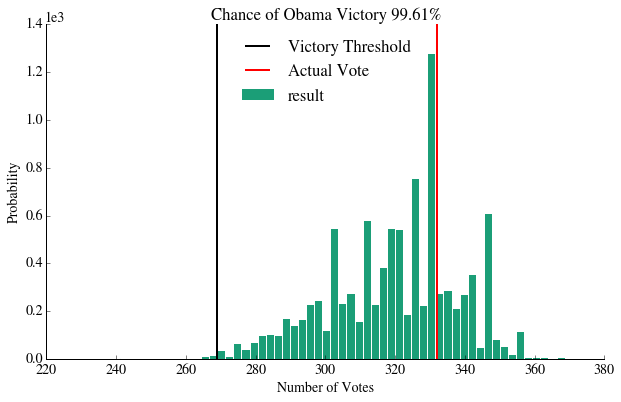

In [701]:
#code to make the histogram
#your code here

prediction = simulate_election(prediction_2012, 10000)
plot_simulation(prediction)

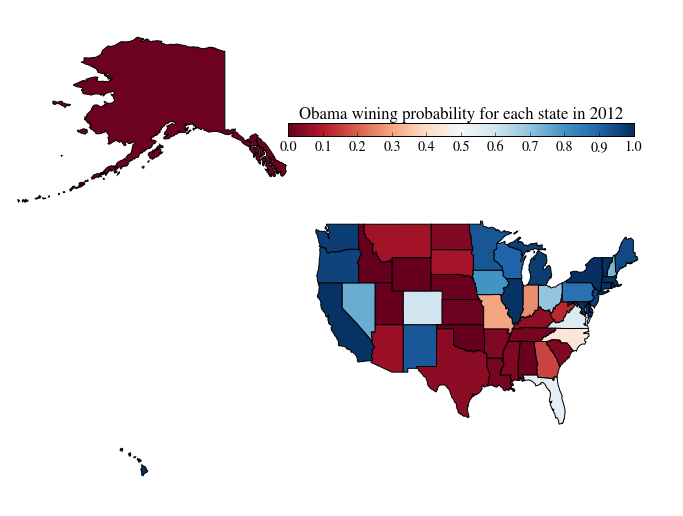

In [698]:
make_map(prediction_2012.Obama, "Obama wining probability for each state in 2012");

Classifier Decision boundary

One nice way to visualize a 2-dimensional logistic regression is to plot the probability as a function of each dimension. This shows the decision boundary -- the set of parameter values where the logistic fit yields P=0.5, and shifts between a preference for Obama or McCain/Romney.

The function below draws such a figure (it is adapted from the scikit-learn website), and overplots the data.

In [699]:
from matplotlib.colors import ListedColormap
def points_plot(e2008, e2012, clf):
    """
    e2008: The e2008 data
    e2012: The e2012 data
    clf: classifier
    """
    Xtrain = e2008[['Dem_Adv', 'pvi']].values
    Xtest = e2012[['Dem_Adv', 'pvi']].values
    ytrain = e2008['obama_win'].values == 1
    
    X=np.concatenate((Xtrain, Xtest))
    
    # evenly sampled points
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    #plot background colors
    ax = plt.gca()
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap='RdBu', alpha=.5)
    cs2 = ax.contour(xx, yy, Z, cmap='RdBu', alpha=.5)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)
    
    # Plot the 2008 points
    ax.plot(Xtrain[ytrain == 0, 0], Xtrain[ytrain == 0, 1], 'ro', label='2008 McCain')
    ax.plot(Xtrain[ytrain == 1, 0], Xtrain[ytrain == 1, 1], 'bo', label='2008 Obama')
        
    # and the 2012 points
    ax.scatter(Xtest[:, 0], Xtest[:, 1], c='k', marker="s", s=50, facecolors="k", alpha=.5, label='2012')
    plt.legend(loc='upper left', scatterpoints=1, numpoints=1)

    return ax

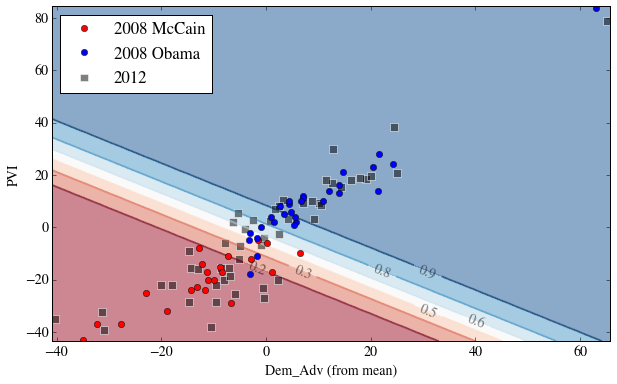

In [710]:
points_plot(e2008, e2012, Regression_Object)
plt.xlabel("Dem_Adv (from mean)")
plt.ylabel("PVI")

The sharpness of the classifier boundary, as defined by the closeness of the contours near a probability of 0.5 gives us a sense of precision. Imagine that the boundary is very tight, tighter than what you can see in the graph. Then most states will be away from the 0.5 line, and the spread in the results will be less, or the precision higher. This is not the only consideration: indeed one must ask, how many states fall smack into the middle, say between 0.3 and 0.7. The more that do, the less precise the results will be, as there will be a greater number of simulations in which they will cross-over to another party.
To assess accuracy, we would have to see the actual outcome of the states in 2012. Accuracy would be a function of the number of states that end up on the "wrong" side of the 0.5 line, and how deep they end up on the wrong side. In terms of characterizing the 2008 outcomes, it seems that the classifier is quit eaccurate, with most misclassifications appearing in grey area of the classification boundary.

#Question 3: Trying to catch Silver: Poll Aggregation

In the previous section, we tried to use heterogeneous side-information to build predictions of the election outcome. In this section, we switch gears to bringing together homogeneous information about the election, by aggregating different polling result together.

This approach -- used by the professional poll analysists -- involves combining many polls about the election itself. One advantage of this approach is that it addresses the problem of bias in individual polls, a problem we found difficult to deal with in problem 1. If we assume that the polls are all attempting to estimate the same quantity, any individual biases should cancel out when averaging many polls (pollsters also try to correct for known biases). This is often a better assumption than assuming constant bias between election cycles, as we did above.

The following table aggregates many of the pre-election polls available as of October 2, 2012. We are most interested in the column "obama_spread". We will clean the data for you:

In [726]:
multipoll = pd.read_csv('./hw2_data/data/cleaned-state_data2012.csv', index_col=0)

#convert state abbreviation to full name
multipoll.State.replace(states_abbrev, inplace=True)

#convert dates from strings to date objects, and compute midpoint
multipoll.start_date = multipoll.start_date.apply(pd.datetools.parse)
multipoll.end_date = multipoll.end_date.apply(pd.datetools.parse)
multipoll['poll_date'] = multipoll.start_date + (multipoll.end_date - multipoll.start_date).values / 2

#compute the poll age relative to Oct 2, in days
multipoll['age_days'] = (today - multipoll['poll_date']).values / np.timedelta64(1, 'D')

#drop any rows with data from after oct 2
multipoll = multipoll[multipoll.age_days > 0]

#drop unneeded columns
multipoll = multipoll.drop(['Date', 'start_date', 'end_date', 'Spread'], axis=1)

#add electoral vote counts
multipoll = multipoll.join(electoral_votes, on='State')

#drop rows with missing data
multipoll.dropna()

multipoll.head(20)

,Pollster,State,MoE,Obama (D),Romney (R),Sample,obama_spread,poll_date,age_days,Votes
0,Rasmussen Reports,Washington,4.5,52,41,500,11,2012-09-26 00:00:00,6.0,12
1,Gravis Marketing,Washington,4.6,56,39,625,17,2012-09-21 12:00:00,10.5,12
2,Elway Poll,Washington,5.0,53,36,405,17,2012-09-10 12:00:00,21.5,12
3,SurveyUSA,Washington,4.4,54,38,524,16,2012-09-08 00:00:00,24.0,12
4,SurveyUSA,Washington,4.4,54,37,524,17,2012-08-01 12:00:00,61.5,12
5,SurveyUSA,Washington,4.0,46,37,630,9,2012-07-17 00:00:00,77.0,12
6,PPP (D),Washington,3.0,54,41,1073,13,2012-06-15 12:00:00,108.5,12
7,Elway Poll,Washington,5.0,49,41,408,8,2012-06-14 12:00:00,109.5,12
8,Strategies 360 (D),Washington,4.4,51,40,500,11,2012-05-23 00:00:00,132.0,12
9,SurveyUSA,Washington,4.2,50,36,557,14,2012-05-08 12:00:00,146.5,12


In [838]:
groupby_state=multipoll.groupby('State')
groupby_state.head()

,Pollster,State,MoE,Obama (D),Romney (R),Sample,obama_spread,poll_date,age_days,Votes
0,Rasmussen Reports,Washington,4.5,52,41,500,11,2012-09-26 00:00:00,6.0,12
1,Gravis Marketing,Washington,4.6,56,39,625,17,2012-09-21 12:00:00,10.5,12
2,Elway Poll,Washington,5.0,53,36,405,17,2012-09-10 12:00:00,21.5,12
3,SurveyUSA,Washington,4.4,54,38,524,16,2012-09-08 00:00:00,24.0,12
4,SurveyUSA,Washington,4.4,54,37,524,17,2012-08-01 12:00:00,61.5,12
17,WeAskAmerica,Wisconsin,2.8,53,41,1238,12,2012-09-21 12:00:00,10.5,10
18,PPP (D),Wisconsin,3.4,52,45,842,7,2012-09-18 12:00:00,13.5,10
19,Rasmussen Reports,Wisconsin,4.5,49,46,500,3,2012-09-17 00:00:00,15.0,10
20,NBC/WSJ/Marist,Wisconsin,3.2,50,45,968,5,2012-09-17 00:00:00,15.0,10
21,Marquette University,Wisconsin,4.1,54,40,601,14,2012-09-14 12:00:00,17.5,10


In [974]:
def state_average(df):
    groupby_state=df.groupby('State')
    averages=groupby_state.describe().unstack().loc[:,(slice(None),['count','mean','std']),]
    averages=averages[['obama_spread']]
    averages.columns=['N', 'poll_mean','poll_std']
    averages.poll_std[averages.poll_std.isnull()]=averages.poll_mean[averages.poll_std.isnull()]*0.05
    return averages

#Simpler implementation
# def state_average(multipoll):
#     groups = multipoll.groupby('State')
#     n = groups.size()
#     mean = groups.obama_spread.mean()
#     std = groups.obama_spread.std()
#     std[std.isnull()] = .05 * mean[std.isnull()]
#     return pd.DataFrame(dict(N=n, poll_mean=mean, poll_std=std))

In [975]:
avg = state_average(multipoll).join(electoral_votes, how='outer')
avg.head()

,N,poll_mean,poll_std,Votes
State,,,,
Alabama,NaN,NaN,NaN,9
Alaska,NaN,NaN,NaN,3
Arizona,20,-5.500000,4.559548,11
Arkansas,3,-20.333333,4.041452,6
California,20,18.950000,5.548589,55


In [976]:
def default_missing(results):
    red_states = ["Alabama", "Alaska", "Arkansas", "Idaho", "Wyoming"]
    blue_states = ["Delaware", "District of Columbia", "Hawaii"]
    results.ix[red_states, ["poll_mean"]] = -100.0
    results.ix[red_states, ["poll_std"]] = 0.1
    results.ix[blue_states, ["poll_mean"]] = 100.0
    results.ix[blue_states, ["poll_std"]] = 0.1
default_missing(avg)
avg.head()

,N,poll_mean,poll_std,Votes
State,,,,
Alabama,NaN,-100.00,0.100000,9
Alaska,NaN,-100.00,0.100000,3
Arizona,20,-5.50,4.559548,11
Arkansas,3,-100.00,0.100000,6
California,20,18.95,5.548589,55


#Unweighted Aggregation
3.2 Build an aggregated_poll_model function that takes the avg DataFrame as input, and returns a forecast DataFrame in the format you've been using to simulate elections. Assume that the probability that Obama wins a state is given by the probability that a draw from a Gaussian with μ=poll_mean and σ=poll_std is positive.

In [977]:
def aggregated_poll_model(df):
    votes=df.Votes
    sigma = df.poll_std
    prob =  .5 * (1 + erf(df.poll_mean / np.sqrt(2 * sigma ** 2)))
    return pd.DataFrame(dict(Obama=prob, Votes=votes))

(250, 400)

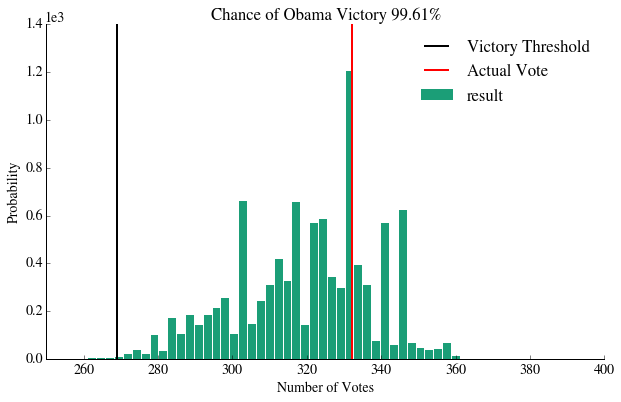

In [980]:
aggregated_pol_model=aggregated_poll_model(avg)
prediction = simulate_election(avg, 10000)
plot_simulation(prediction)
plt.xlim(250, 400)

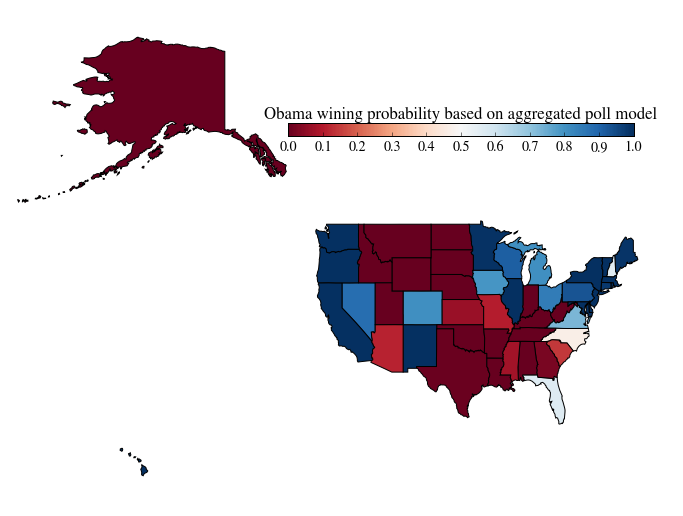

In [979]:
make_map(aggregated_pol_model.Obama, "Obama wining probability based on aggregated poll model");

The accuracy of this poll is somewhat greater than just taking the gallup poll. 
This is probably because
We're using as inputs polls that are trying to predict the election, so there is nothing "lost in translation", and
We are averaging many polls together, so some of their biases are likely to offset each other.

One problem is that we treated all polls as equal. Thus a bad poll with a small sample size is given equal footing as a good poll with a large one. Thus we are introducing bias both due to individual poll biases and individual poll sampling errors.

#Weighted Aggregation

Not all polls are equally valuable. A poll with a larger margin of error should not influence a forecast as heavily. Likewise, a poll further in the past is a less valuable indicator of current (or future) public opinion. For this reason, polls are often weighted when building forecasts.

In [981]:
multipoll[multipoll.State=="Kansas"]

,Pollster,State,MoE,Obama (D),Romney (R),Sample,obama_spread,poll_date,age_days,Votes
427,SurveyUSA,Kansas,4.4,39,48,510,-9,2011-11-19 12:00:00,317.5,6
428,SurveyUSA,Kansas,3.5,31,56,800,-25,2011-11-10 00:00:00,327.0,6


here are only two polls in the last year! And, the results in the two polls are far, very far from the mean.
Now, Kansas is a safely Republican state, so this dosent really matter, but if it were a swing state, we'd be in a pickle. We'd have no unbiased estimator of the variance in Kansas. So, to be conservative, and play it safe, we follow the same tack we did with the unweighted averaging of polls, and simply assume that the variance in a state is the square of the standard deviation of obama_spread.

In [982]:
def weights(df):
    lam_age = .5 ** (df.age_days / 30.)
    w = lam_age / df.MoE ** 2
    return w

def wmean(df):
    w = weights(df)
    result = (df.obama_spread * w).sum() / w.sum()
    return result

def wsig(df):
    return df.obama_spread.std()

def weighted_state_average(multipoll):
        
    groups = multipoll.groupby('State')
    poll_mean = groups.apply(wmean)
    poll_std = groups.apply(wsig)
    poll_std[poll_std.isnull()] = poll_mean[poll_std.isnull()] * .05
    
    return pd.DataFrame(dict(poll_mean = poll_mean, poll_std = poll_std))

3.5 Put this all together -- compute a new estimate of poll_mean and poll_std for each state, apply the default_missing function to handle missing rows, build a forecast with aggregated_poll_model, run 10,000 simulations, and plot the results, both as a histogram and as a map.

(250, 400)

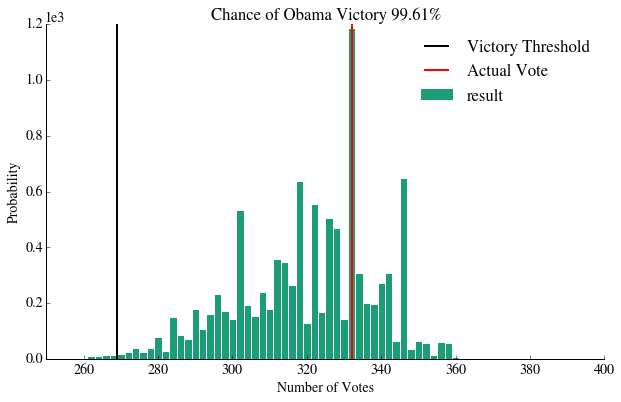

In [983]:
average = weighted_state_average(multipoll)
average = average.join(electoral_votes, how='outer')
default_missing(average)
model = aggregated_poll_model(average)
sims = simulate_election(model, 10000)
plot_simulation(sims)
plt.xlim(250, 400)

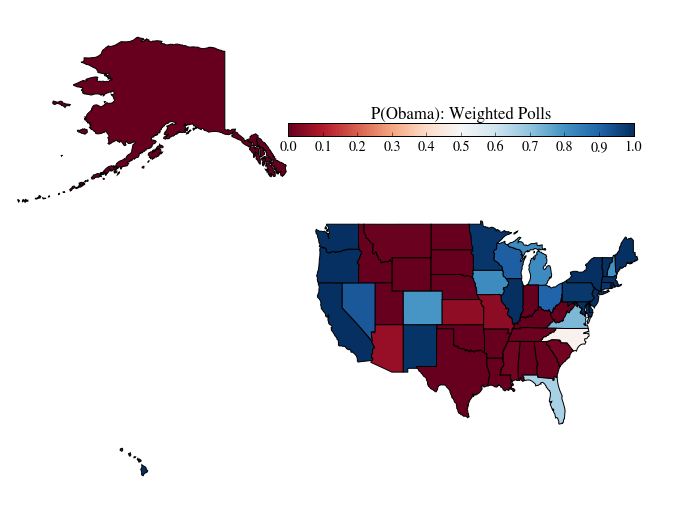

In [984]:
make_map(model.Obama, "P(Obama): Weighted Polls")